In [1]:
from qiskit import QuantumCircuit, assemble, Aer
import numpy as np
from qiskit.visualization import plot_histogram, plot_bloch_vector, array_to_latex, plot_bloch_multivector
from math import sqrt, pi
from IPython.display import display, Math
from qiskit.quantum_info import random_statevector
svsim = Aer.get_backend('aer_simulator') 

# Q1
To solve a general 3 SAT problem, we would define the Grover oracle to flip the phase of the system by $\pi$, if the binary expression formed by the qubit states in a standard basis state satisfies the boolean function.<br>
# Q2
The OR gate is implemented as shown below.<br>
The NOT gate is just the X gate.<br>
And the AND gate can be implemented using the Toffoli gate.

In [2]:
def my_or(qc, a, b, c):
    qc.cx(a, c)
    qc.cx(b, c)
    qc.ccx(a, b, c)

To define a general procedure, we define a function to add a clause to our circuit.<br>
Its input is a tuple (n1, a, n2, b, n3, c) where booleans n1, n2, n3 signify whether the literal is in negation. a, b, c signify the qubit/vector index used in the clause.<br>
We also feed in the indices of the work qubits and use repeated OR gates to store the result in a work qubit initialized to 0.

In [3]:
def add_clause(qc, clause, result_qubit, w): #clause = (n1, a, n2, b, n3, c)
    if len(clause) == 6:
        if(clause[0]): 
            qc.x(clause[1])
        if(clause[2]):
            qc.x(clause[3])
        if(clause[4]):
            qc.x(clause[5])
        my_or(qc, clause[1], clause[3], w)
        my_or(qc, w, clause[5], result_qubit)
        my_or(qc, clause[1], clause[3], w)
        if(clause[0]): 
            qc.x(clause[1])
        if(clause[2]):
            qc.x(clause[3])
        if(clause[4]):
            qc.x(clause[5])
    elif len(clause) == 4:
        if(clause[0]): 
            qc.x(clause[1])
        if(clause[2]):
            qc.x(clause[3])
        my_or(qc, clause[1], clause[3], result_qubit)
        if(clause[0]): 
            qc.x(clause[1])
        if(clause[2]):
            qc.x(clause[3])
    elif len(clause) == 2:
        if(clause[0]): 
            qc.x(clause[1])
        qc.cx(clause[1], result_qubit)
        if(clause[0]): 
            qc.x(clause[1])

This is the standard initial state for Grover's search. This implementation uses $n+2*m$ qubits generally, where $n$ is the dimension of the input vector, and $m$ is the number of clauses.

In [4]:
def init(qc, n, m):
    qc.x(n+2*m-1)
    for i in range(n):
        qc.h(i)
    qc.h(n+2*m-1)
    qc.barrier()

The oracle is defined by using the clauses given in a list. It uses repeated AND gates on the results of individual clauses and the target qubit is flipped if all are 1.

In [5]:
def oracle(qc, clauses, results, w):
    m = len(clauses)
    for i in range(m):
        add_clause(qc, clauses[i], results[i], w)
        qc.barrier()
    qc.ccx(results[0], results[1], results[m])
    for i in range(2, m):
        qc.ccx(results[i], results[m-2+i], results[m-1+i])
    #flip_bit is results[2m-2]
    for i in range(m-2, 1, -1):
        qc.ccx(results[i], results[m-2+i], results[m-1+i])
    qc.ccx(results[0], results[1], results[m])
    for i in range(m):
        add_clause(qc, clauses[i], results[i], w)
        qc.barrier()

This function adds the gate which flips the quantum system's state about the state $\psi_0 = \frac{1}{\sqrt{2^n}}\sum_{x\in\{0,1\}^n}|x\rangle$. <br>
It does so by implementing $-H^{\otimes n}(I-2|0\rangle\langle 0|)H^{\otimes n} = 2|\psi_0\rangle\langle \psi_0|-I$.<br>
Where $I-2|0\rangle\langle 0|$ is a gate that flips the phase of only the $|0\rangle$ state. This is implemented by using the NOT gate on all the computational qubits, and using the Z gate, if all are found to be 1. <br>

In [6]:
def refl_about_avg(qc, n):
    for i in range(n):
        qc.h(i)
        qc.x(i)
    qc.barrier()
    qc.ccx(0, 1, n)
    for i in range(2, n-1):
        qc.ccx(i, n-2+i, n-1+i)
    qc.cz(2*n-3, n-1)
    for i in range(n-2, 1, -1):
        qc.ccx(i, n-2+i, n-1+i)
    qc.ccx(0, 1, n)
    qc.x(n)
    qc.cz(n, n-1)
    qc.x(n)
    qc.barrier()
    for i in range(n):
        qc.x(i)
        qc.h(i)
    qc.barrier()

# Q3 The final implementation
Using all the pre-defined functions, the circuit for $F^*$ is as follows.<br>
To refine the search, I have used an extra qubit and added the clause that it be 1 for $F^*$ to return 1.<br>
Thus, we have 13 valid states out of 64 rather than 32, which gives a more suitable $\theta$ (as defined in QCQI).<br>
Using 1 iteration, our state comes very close to the "solution vector", as can be seen in the histogram.

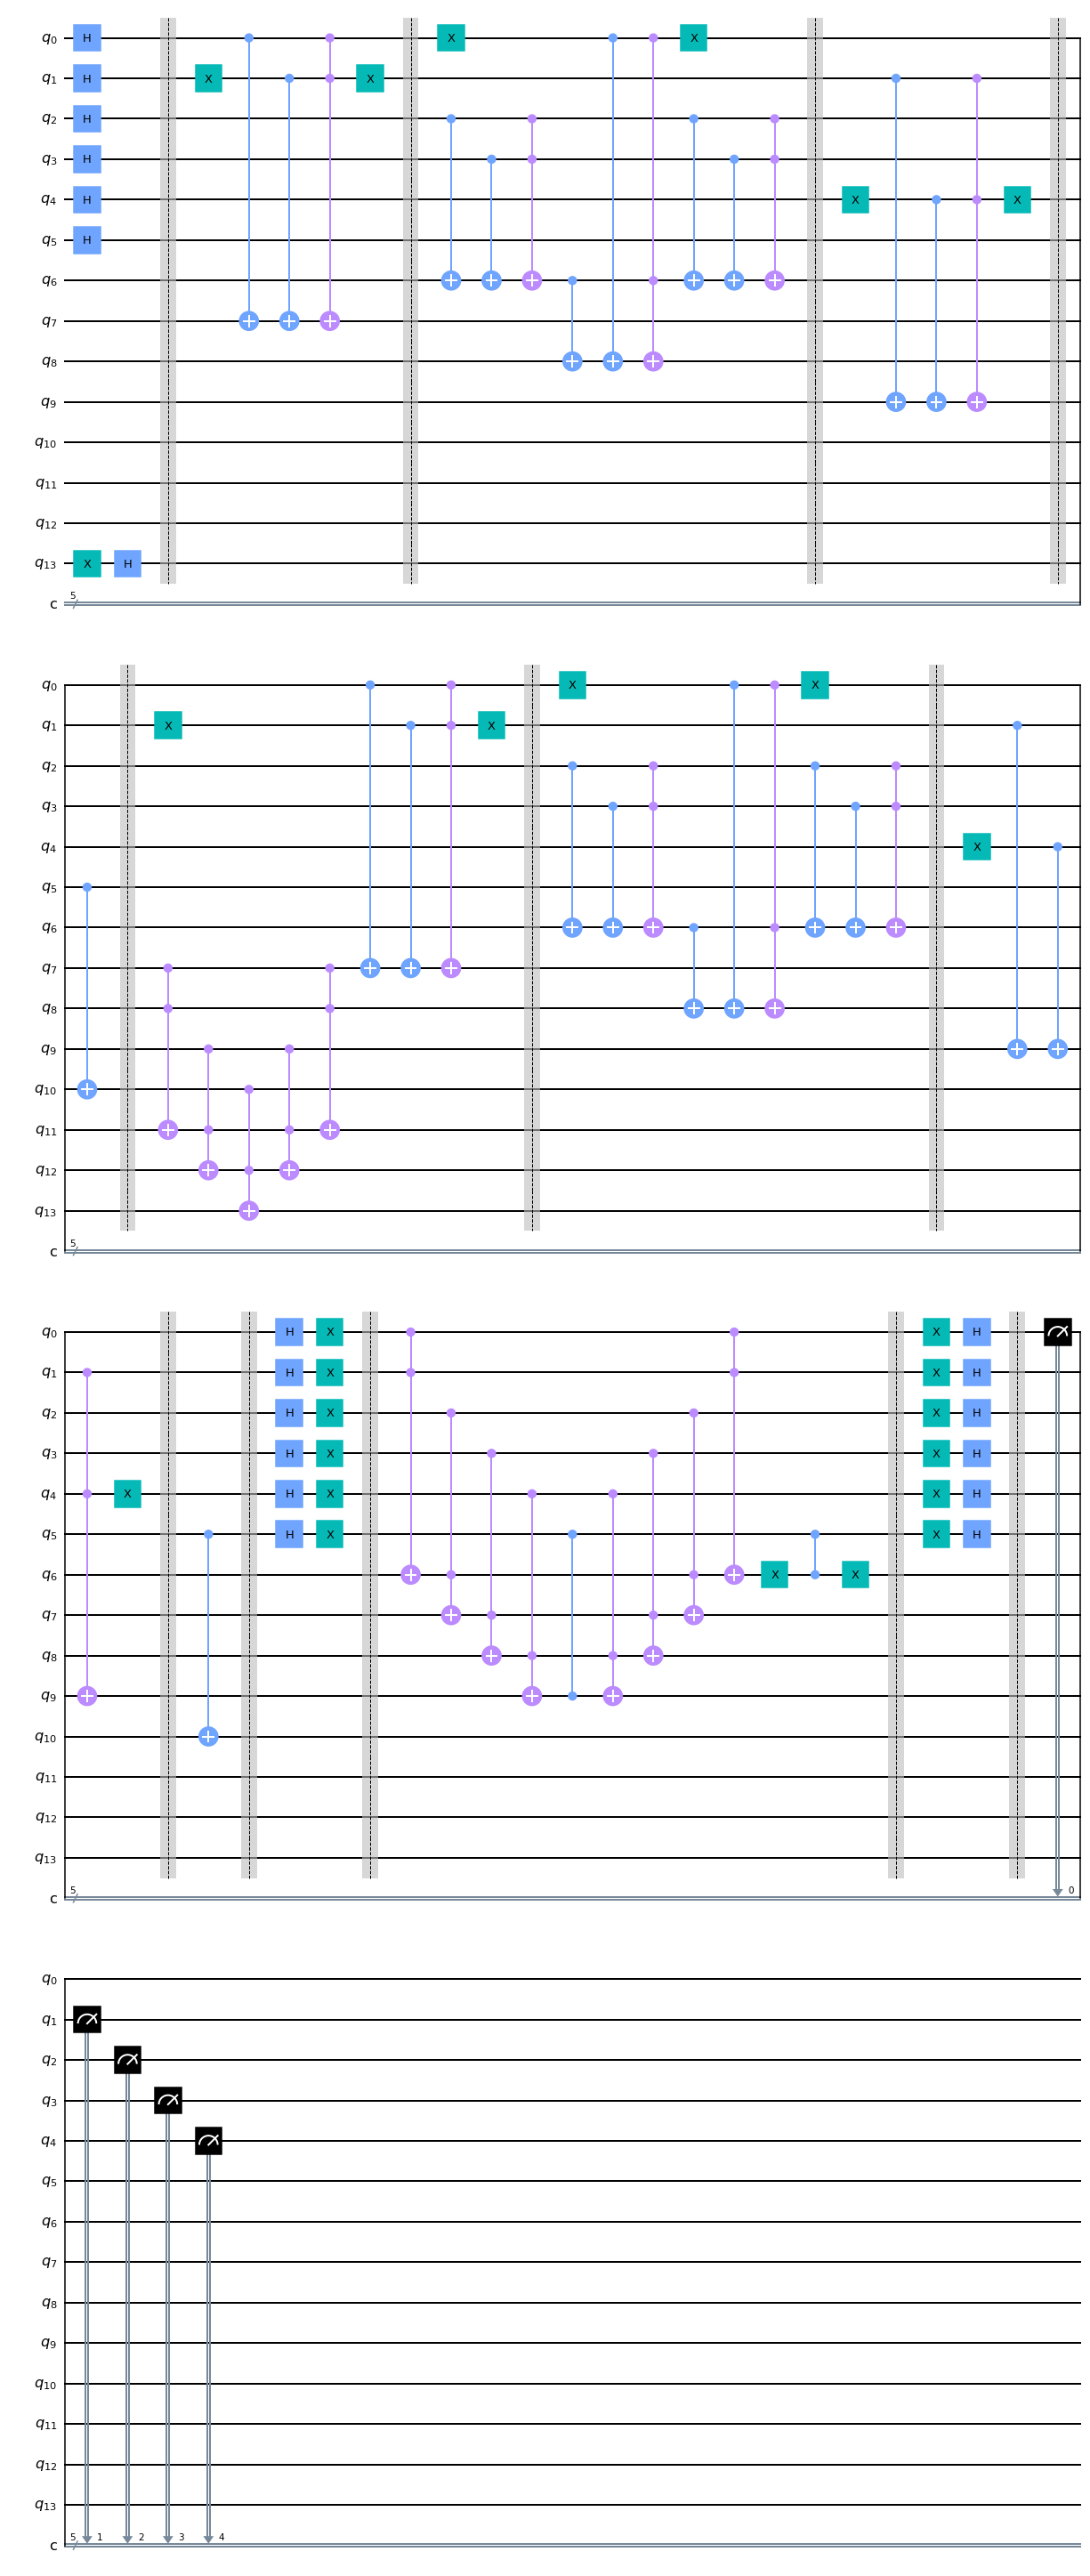

In [7]:
n = 6
m = 4
qc = QuantumCircuit(n + 2*m, n-1)
clauses = [(0,0,1,1), (0,2,0,3,1,0), (0,1,1,4), (0, 5)]
work_q = n
results = list(range(n+1, n+2*m))
qubits = list(range(n-1))
init(qc, n, m)
oracle(qc, clauses, results, work_q)
refl_about_avg(qc, n)
qc.measure(qubits, qubits)
qc.draw('mpl')

In [8]:
counts = svsim.run(assemble(qc)).result().get_counts()
dict(sorted(counts.items(), key=lambda item: item[1]))
#x_4 x_3 x_2 x_1 x_0

{'01010': 1,
 '10100': 1,
 '11001': 1,
 '01110': 1,
 '11101': 1,
 '11110': 1,
 '00011': 1,
 '11000': 2,
 '00110': 2,
 '11100': 2,
 '10110': 3,
 '10101': 3,
 '10000': 3,
 '11011': 69,
 '00100': 74,
 '00000': 75,
 '11111': 75,
 '01111': 75,
 '10111': 76,
 '00111': 77,
 '01000': 77,
 '00101': 77,
 '01011': 77,
 '01001': 81,
 '01101': 84,
 '01100': 85}

# The solutions
After adjusting for the Qiskit ordering of bits, the solutions to the particular SAT problem, $F^*$ are:<br>
$$F^* (x_1, x_2, x_3, x_4, x_5) = (x_1\lor \neg x_2)\land(x_3\lor x_4\lor \neg x_1)\land(x_2 \lor \neg x_5)$$
$$x_1 x_2 x_3 x_4 x_5 = \{00000, 00010, 00100, 00110, 10010, 10100,10110, 11010, 11011, 11100, 11101, 11110, 11111\}$$

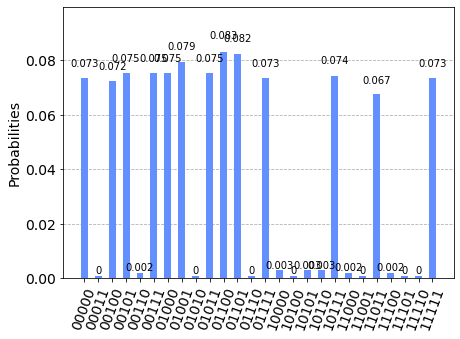

In [9]:
plot_histogram(counts)